## <center> Automated extraction of water bodies from NIR and RGB aerial imagery in northern Alaska using supervised and unsupervised machine learning techniques </center>

### <center> Random Forest Classification for NIR images <center>
##### <center> Prepared By : Ahmed Abdelwahab <center>

The aim of my code is to apply random forest classification for NIR raster images collected using Airborne photogrammetry. The main goal is study the water bodies degradation.

The code also provides an accuracy assessment method to validate the training sample data before clustering all pixels in my images. 

The code was generally useful to have fair classification as the spatial resolution was 1 meter and sensitive to minor details unlike satellite images of 15-30 meter spatial resolution.

A useful tip in some noisy images to apply smoothing filters such as (Major filters or Nearest neighbors using either 4 or 8 pixels). furthermore, you can start test some morphology algorithms to clean the data before running the classification.

In [1]:
import rasterio
import rasterio.features
import rasterio.warp
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.datasets import make_classification
import geopandas as gpd
from sklearn.model_selection import train_test_split
from shapely.geometry import mapping
from rasterio.mask import mask
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.metrics import plot_confusion_matrix
import os
import multiprocessing as mp
from scipy.ndimage import gaussian_filter
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import skimage.morphology
from skimage.morphology import (erosion, dilation, opening, closing,  # noqa
                                white_tophat)
from skimage.morphology import black_tophat, skeletonize, convex_hull_image  # noqa
print("Number of processors: ", mp.cpu_count())

Number of processors:  4


##### Reading the training data and Image

First step to define the directory were yoy stored your shapefiles and images.

In [2]:
# Define the data directory
os.chdir('D:/Deutschland/Potsdam University/Master_Thesis/Data/Orthomosaic/NIR')

# reading the training sample file(shapefile format)
shapefile = "MeadeWest_NIR_transparent_mosaic_nir_3c_tif2.shp"

train = gpd.read_file(shapefile)

In [3]:
# Visualize the training sample data
train

,Classname,Classvalue,RED,GREEN,BLUE,Count,geometry
0,water,1,197,0,255,14843,"POLYGON ((333518.700 7764370.208, 333507.059 7..."
1,Wet_vegetation,2,255,255,190,763,"POLYGON ((333718.197 7764374.970, 333714.757 7..."
2,Pasture,3,230,152,0,194,"MULTIPOLYGON (((333768.785 7764317.582, 333767..."


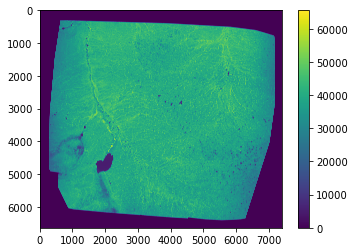

In [4]:
# Reading and visualizing the raster image
im = rasterio.open('MeadeWest_NIR_transparent_mosaic_NIR_10_2.tif')
im.transform

plt.imshow(im.read(1))
plt.colorbar()

##### Data preprocessing (Manupilation)
Reading the data and convert it to Numpy array and use the training data as Polygons so it will be used for validation

In [5]:
# Reshape of the NIR band (Empty array) 
# This array is prepared for pixel values from areas that polygon cover
X = np.array([], dtype=np.float32).reshape(1, -1)

# labels for training(Empty Array)
# This array is for labels/classes
y = np.array([], dtype=np.string_)

# create empty list to append all classes with their pixel values based on the training sample
out_image = []
for i in range(0,3): # number of iterations is based on the number of classes
    values = train.geometry.values[i]
    pol = [mapping(values)]
    classname = train['Classname'][i]
    out_im=mask(im, pol, crop=True, filled=True)[0]
    out_image=out_im[:, ~np.all(out_im == 0, axis=0)]    
    y = np.append(y, [classname] * out_image.shape[1]) 
    X = np.hstack((X, out_image))

In [6]:
# NIR image bands - reshaped (data x 3), as this is the shape sklearn accepts
X = np.moveaxis(X, 0, -1)

# Training sample as string(T.data x 0)
y = np.moveaxis(y, 0, -1)

Apply a smoothing Gaussian filter which was tested using sigma 0.2 and can be changed based on your data

In [7]:
# Applying Gaussian filter to our image
X = gaussian_filter(X, sigma=0.2)

#### Training the model

At first only the selected pixels which already known from the Training sample file and original data. The validation works using 75% of the training data to vaildate the accuracy of the tested polygons.

In [8]:
# Define Training and test datasets before running the classification, by splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, shuffle=True, stratify=None)

# Create the model of RandomForestClassifier with 100 trees/estimators
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt', n_jobs=-1)

# Fitting the model with training data
model.fit(X_train, y_train.reshape(-1,1).ravel())

RandomForestClassifier(max_features='sqrt', n_jobs=-1)

In [9]:
# predict the classes using 75% of the training sample data file (Apply RFC)
prd = model.predict(X_test)

In [10]:
# prediction vs main training sample accuracy report
print(classification_report(y_test, prd))

                precision    recall  f1-score   support

       Pasture       0.97      0.98      0.97        57
Wet_vegetation       0.99      0.99      0.99       188
         water       1.00      1.00      1.00      3706

      accuracy                           1.00      3951
     macro avg       0.99      0.99      0.99      3951
  weighted avg       1.00      1.00      1.00      3951



In [11]:
# Estimate classification accuracy scores
print('Accuracy Score : ', accuracy_score(y_test, prd))

Accuracy Score :  0.9992406985573272


In [12]:
#Estimate Confusion matrix
confusion_matrix(y_test, prd)

array([[  56,    1,    0],
       [   2,  186,    0],
       [   0,    0, 3706]], dtype=int64)

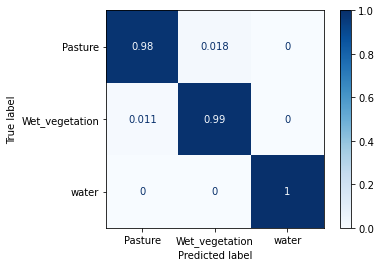

In [13]:
# Plot the accuracy assessment (Confusion matrix)
# Normalized values
plot_confusion_matrix(model, X_test, y_test,cmap=plt.cm.Blues,normalize=('true'))

The validation of the predicted labels results presented above and the diagonal present te accuracy percentage between true label Vs Predicted label.

#### Applying the trained model to whole image

In [14]:
# create input reshaped data for all pixels in raster images
X_prd = im.read()
X_prd = np.moveaxis(X_prd, 0, -1)
fx = []
for i in range(1):
    fx.append(X_prd[:, :, i].flatten())
X_pred = np.array(fx).T

In [15]:
# Predicting classes
y_pred_img = model.predict(X_pred)

In [16]:
# Encoding the labels and use numbers to replace the strings
le = preprocessing.LabelEncoder()
le.fit(y_pred_img)
label = le.transform(y_pred_img)

In [17]:
# rehshaping predicted pixels to original image's shape
label.shape = im.read(1).shape

#### Visualization of the Prediction Result

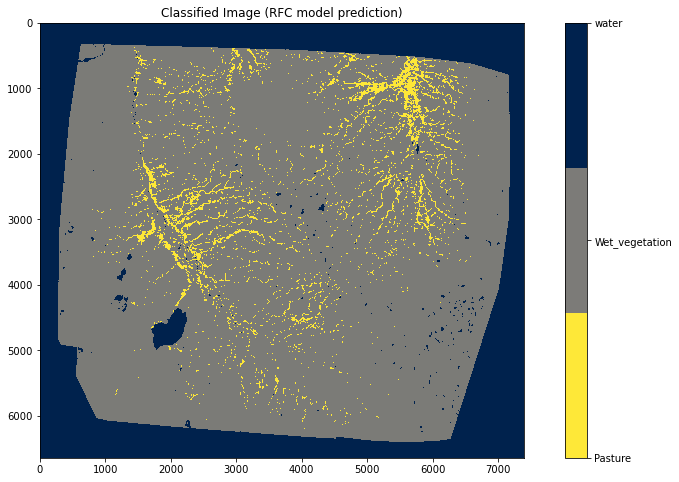

In [18]:
# Plot the classified data
plt.figure(figsize = (15, 8))
im = plt.imshow(label, cmap=plt.cm.get_cmap('cividis_r', len(np.unique(y_pred_img))))
plt.title('Classified Image (RFC model prediction)')
cbar=plt.colorbar(im)
cbar.set_ticks(np.arange(len(np.unique(y_pred_img))))
cbar.set_ticklabels(np.unique(y_pred_img))

#### Post-processing of the Classified Image

In [19]:
# Post Classification filtering through Morphological filter (Closing)
label2 = closing(label)

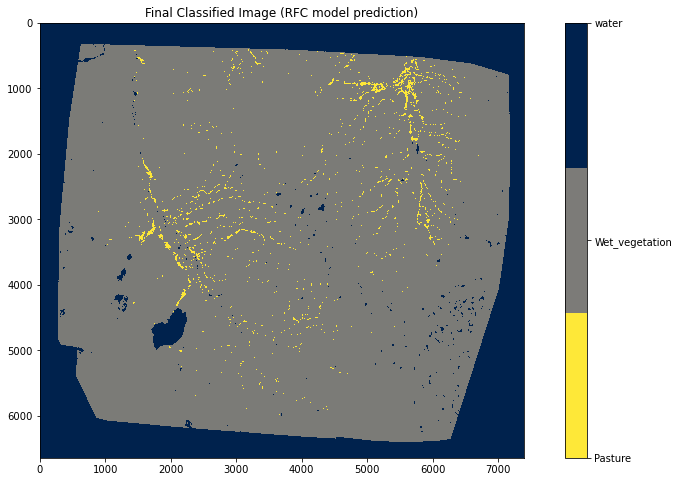

In [20]:
# Plot the classified data
plt.figure(figsize = (15, 8))
im = plt.imshow(label2, cmap=plt.cm.get_cmap('cividis_r', len(np.unique(y_pred_img))))
plt.title('Final Classified Image (RFC model prediction)')
cbar=plt.colorbar(im)
cbar.set_ticks(np.arange(len(np.unique(y_pred_img))))
cbar.set_ticklabels(np.unique(y_pred_img))

#### Extraction of the Classified Image as a TIF file

In [21]:
# extract the projection from the original image to use it for writing the raster image
src = rasterio.open('MeadeWest_NIR_transparent_mosaic_NIR_10_2.tif')
src.crs

CRS.from_epsg(32605)

In [22]:
# Write the raster image after classification
with rasterio.open('class/MeadeWest_NIR_transparent_mosaic_nir_20_4classes.tif', 'w',width=label2.shape[1], height=label2.shape[0],count=1, transform=src.transform,
                   dtype=(label2).dtype) as dst:
    dst.write(label2, indexes=1)